In [1]:
from tensorflow import keras
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import textwrap

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from scipy import interp
from itertools import cycle

In [2]:
phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan',
    'unknown': 'black'
}

In [3]:
efam_super_annote = pd.read_csv('../general_data_files/Final_Super_Condensed_Annotations-updated_efam.tsv', sep='\t')
## convert 'Proteins' column read in as a string into a column of lists
efam_super_annote['Proteins'] = efam_super_annote['Proteins'].apply(literal_eval)

In [4]:
efam_super_annote = efam_super_annote.set_index(keys='Cluster')

In [5]:
efam_cluster_protein_lengths = pd.read_csv('efam_cluster_average_protein_length.csv', header=None, names=['Cluster', 'average_protein_length'])

In [6]:
efam_super_annote = efam_super_annote.merge(efam_cluster_protein_lengths, left_index=True, right_on='Cluster')
efam_super_annote = efam_super_annote.set_index(keys='Cluster')

In [7]:
efam_phrog_predicted = pd.read_csv('efam_phrog_e10.csv', index_col=0)
phrog_metadata = pd.read_csv('../general_data_files/PHROG_index_revised_v4_10292022.csv')

In [8]:
cs = list(set(efam_phrog_predicted['cluster']))
efam_phrog_annotated = efam_super_annote[efam_super_annote.index.isin(cs)]

In [9]:
lb = {}
for c in tqdm(cs):
    ps = efam_phrog_predicted[efam_phrog_predicted['cluster'] == c]['phrog#']
    l = list(phrog_metadata[phrog_metadata['#phrog'].isin(ps)]['Category'])
    u, ind = np.unique(l, return_index=True)
    q = u[np.argsort(ind)]
    
    ## if the only phrog hit has an 'unknown function' annotation, remove from test set
    if q[0] == 'unknown function':
        if len(q) < 2:
            continue
        else:
            lb[c] = q
    else:
        lb[c] = q

100%|█████████████████████████████████████| 88605/88605 [15:34<00:00, 94.83it/s]


In [10]:
## load all efam cluster predictions
efam_cluster_probs = pd.read_csv('efam_clusters_all_probabilities.tsv', sep='\t', index_col=0)
efam_cluster_probs_np = efam_cluster_probs.to_numpy()

In [11]:
phrog_classes = list(efam_cluster_probs.columns)

In [12]:
# convert the labels from integers to vectors
label_binarizer = LabelBinarizer()
label_binarizer.fit(phrog_classes)

LabelBinarizer()

In [13]:
preds = []
efamY = []
for c in tqdm(lb.keys()):
    
    if c not in efam_cluster_probs.index:
        print(c)
        continue
    
    truth = lb[c]
    if truth[0] == 'unknown function':
        if len(truth) == 1:
            efamY.append('unknown')
        else:
            efamY.append(truth[1])
    else:
        efamY.append(truth[0])
    
    preds.append(efam_cluster_probs_np[efam_cluster_probs.index.get_loc(c)])


efamY = label_binarizer.transform(efamY)
preds = np.array(preds)

100%|█████████████████████████████████| 66137/66137 [00:00<00:00, 377012.05it/s]


In [14]:
print(classification_report(efamY.argmax(axis=1), preds.argmax(axis=1), target_names=label_binarizer.classes_))

/opt/anaconda3/envs/tf-apple/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                   precision    recall  f1-score   support

               DNA, RNA and nucleotide metabolism       0.94      0.89      0.92     20240
                                        connector       0.76      0.72      0.74      2412
                               head and packaging       0.90      0.79      0.85     15601
                         integration and excision       0.98      0.90      0.94       484
                                            lysis       0.88      0.69      0.77      2237
moron, auxiliary metabolic gene and host takeover       0.84      0.79      0.81      4414
                                            other       0.88      0.64      0.74      7810
                                             tail       0.89      0.83      0.86     12257
                         transcription regulation       0.96      0.79      0.86       682
                                          unknown       0.00      0.00      0.00         

/opt/anaconda3/envs/tf-apple/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-apple/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
supports = [20240, 2412, 15601, 484, 2237, 4414, 7810, 12257, 682]

In [16]:
print('Fraction of EFAM annotated with PHROG function by HMM: {0}' ''.format(sum(supports) / len(efam_phrog_annotated)))

Fraction of EFAM annotated with PHROG function by HMM: 0.7464251453078269


# figure 4a

In [17]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 16

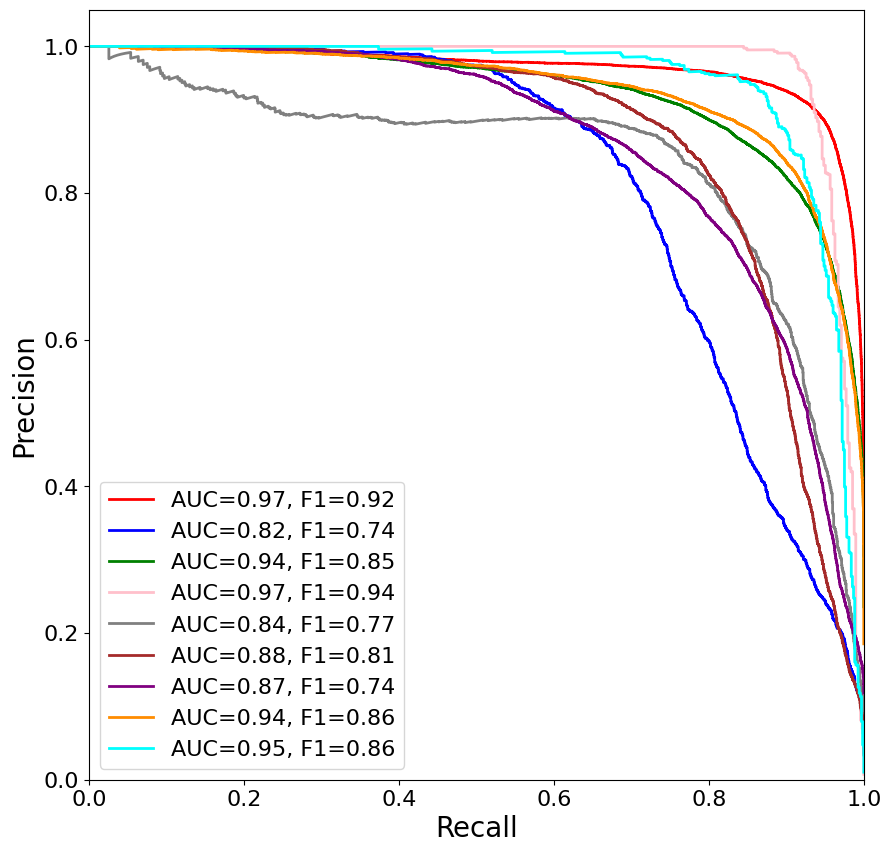

In [18]:
# Plot linewidth.
lw = 2
## n_classes -1 is to remove the unknown class
n_classes = len(label_binarizer.classes_)-1

# make prediction on testX for plotting
predY = preds
testY = efamY

fscores = f1_score(efamY.argmax(axis=1), preds.argmax(axis=1), average=None)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
roc_auc = dict()
roc_auprc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], predY[:, i])
    precision[i], recall[i], _ = precision_recall_curve(testY[:, i], predY[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auprc[i] = auc(recall[i], precision[i])



for i in range(n_classes):
    color = phrog_palette[label_binarizer.classes_[i]]
    
    
    #fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    # locate the index of the largest f score
    #ix = np.nanargmax(fscore)
    #plt.scatter(recall[i][ix], precision[i][ix], marker='|', color=color, s=30**2)
    
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='AUC={0:0.2f}, F1={1:0.2f}'
             ''.format(roc_auprc[i], fscores[i]))



#plt.scatter(x=0, y=0, marker='|', color='black', s=20**2, label='Maximum F1 threshold')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)

plt.legend(loc="lower left")
plt.savefig('performance_efam_validation_AUPRC.png', dpi=300, bbox_inches='tight')
plt.show()

# supplemental figure 4

In [19]:
sns.reset_defaults()
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams['font.size'] = 16

Best Threshold DNA, RNA and nucleotide metabolism= 0.246891, F-Score=0.925,  FDR=0.080
Best Threshold connector= 0.566061, F-Score=0.759,  FDR=0.166
Best Threshold head and packaging= 0.172412, F-Score=0.862,  FDR=0.157
Best Threshold integration and excision= 0.455388, F-Score=0.947,  FDR=0.013
Best Threshold lysis= 0.187529, F-Score=0.809,  FDR=0.178
Best Threshold moron, auxiliary metabolic gene and host takeover= 0.425248, F-Score=0.816,  FDR=0.155
Best Threshold other= 0.155121, F-Score=0.787,  FDR=0.211
Best Threshold tail= 0.289085, F-Score=0.874,  FDR=0.131
Best Threshold transcription regulation= 0.294141, F-Score=0.904,  FDR=0.064


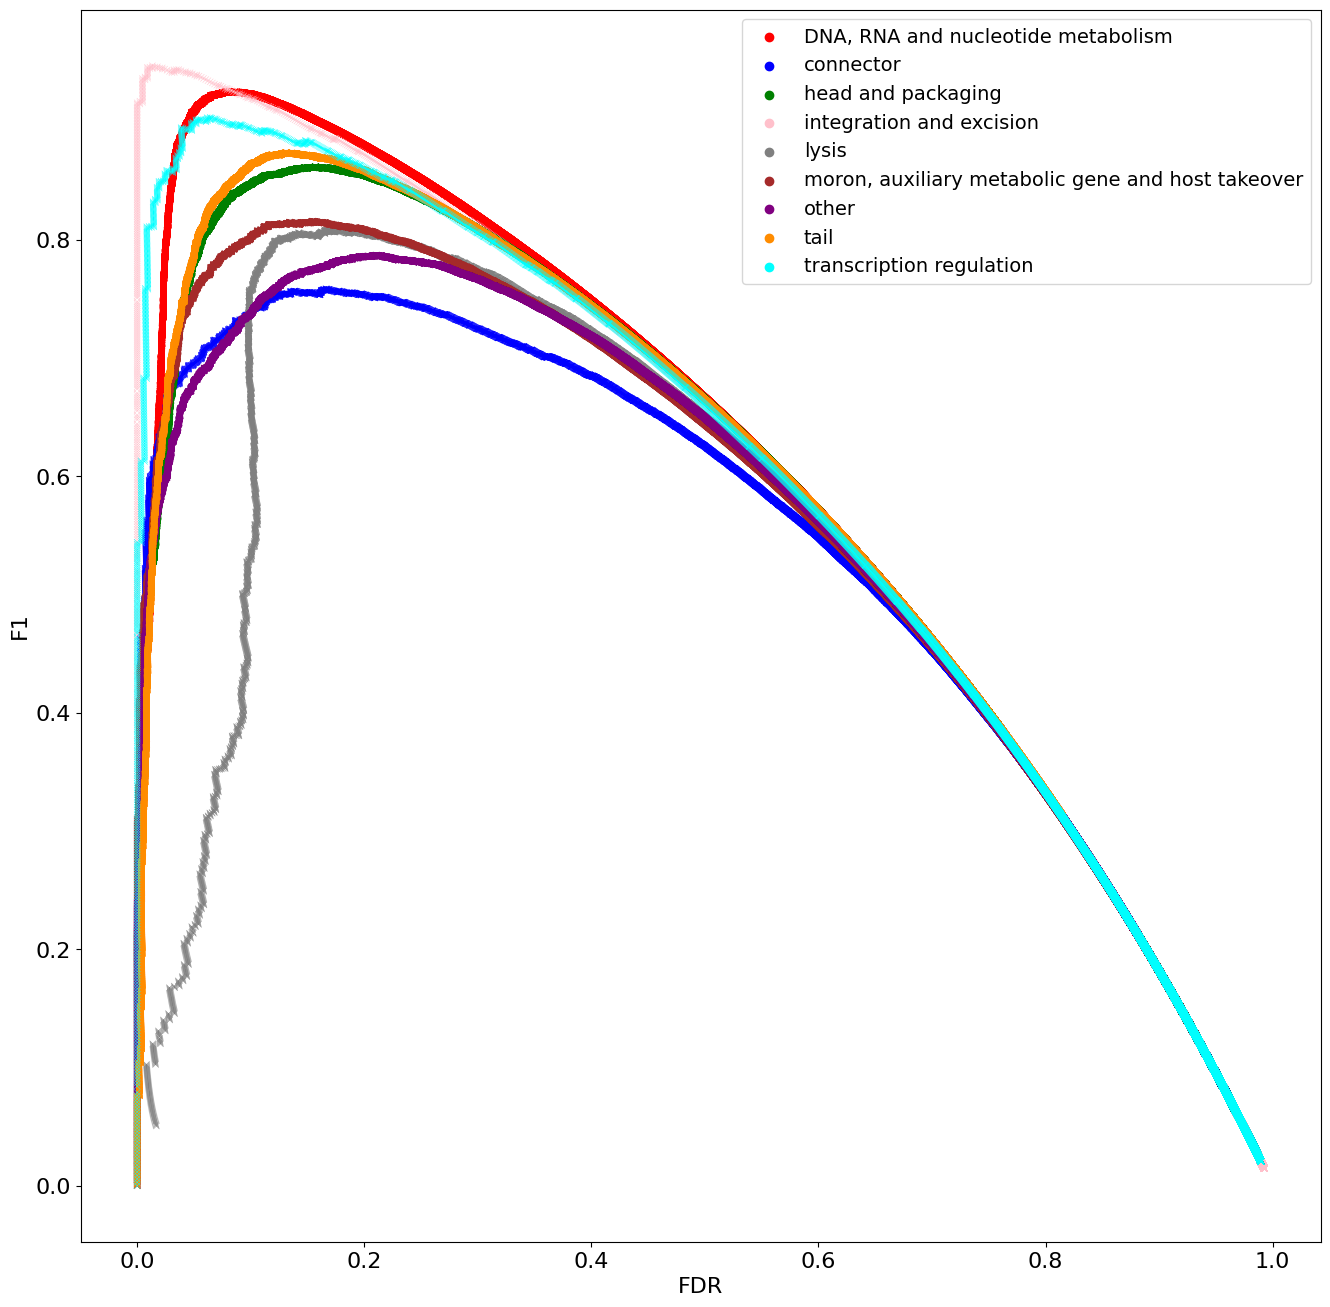

In [20]:
## threshold based on F1 score
decision_threshold = {}
thresholded_fscores = []
fdr_rates = {}
f_fdr_df = pd.DataFrame(columns=['fscore', 'fdr', 'class'])
for i in range(len(label_binarizer.classes_)-1):

    precision, recall, thresholds = precision_recall_curve(testY[:, i], predY[:, i])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fdr = 1 - precision
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    print('Best Threshold %s= %f, F-Score=%.3f,  FDR=%.3f' % (label_binarizer.classes_[i], thresholds[ix], fscore[ix], fdr[ix]))
    
    decision_threshold[label_binarizer.classes_[i]] = thresholds[ix]
    thresholded_fscores.append(fscore[ix])
    
    category = [label_binarizer.classes_[i]] * len(fscore)
    df = pd.DataFrame({'fscore': fscore, 'fdr':fdr, 'class': category})
    f_fdr_df = pd.concat([f_fdr_df, df])


sns.scatterplot(data=f_fdr_df, x='fdr', y='fscore', hue='class', palette=phrog_palette, marker='x', s=20)
plt.xlabel('FDR')
plt.ylabel('F1')
plt.legend(loc='upper right', fontsize=14)
plt.savefig('F1_by_FDR_model_plot.png', dpi=300)
plt.show()

# supplemental table 4

In [21]:
FDR = 0.10

In [22]:
# threshold based on F1 score
decision_threshold = {}
thresholded_fscores = []
for i in range(len(label_binarizer.classes_)-1):

    precision, recall, thresholds = precision_recall_curve(testY[:, i], predY[:, i])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fdr = 1 - precision

    # locate the FDR threshold 
    fdr_threshold = fdr < FDR
    
    
    
    ix = np.where(fdr_threshold)[0][np.nanargmax(fscore[np.where(fdr_threshold)])]
    # locate the index of the largest f score
    print('Best Threshold %s= %.2f, F-Score=%.2f,  FDR=%.2f, Precision=%.2f, Recall=%.2f' % 
          (label_binarizer.classes_[i], thresholds[ix], fscore[ix], fdr[ix], precision[ix], recall[ix]))
    
    decision_threshold[label_binarizer.classes_[i]] = thresholds[ix]
    thresholded_fscores.append(fscore[ix])

Best Threshold DNA, RNA and nucleotide metabolism= 0.25, F-Score=0.93,  FDR=0.08, Precision=0.92, Recall=0.93
Best Threshold connector= 0.74, F-Score=0.74,  FDR=0.10, Precision=0.90, Recall=0.63
Best Threshold head and packaging= 0.41, F-Score=0.85,  FDR=0.10, Precision=0.90, Recall=0.80
Best Threshold integration and excision= 0.46, F-Score=0.95,  FDR=0.01, Precision=0.99, Recall=0.91
Best Threshold lysis= 0.53, F-Score=0.76,  FDR=0.10, Precision=0.90, Recall=0.65
Best Threshold moron, auxiliary metabolic gene and host takeover= 0.64, F-Score=0.80,  FDR=0.10, Precision=0.90, Recall=0.72
Best Threshold other= 0.50, F-Score=0.74,  FDR=0.10, Precision=0.90, Recall=0.62
Best Threshold tail= 0.45, F-Score=0.86,  FDR=0.10, Precision=0.90, Recall=0.83
Best Threshold transcription regulation= 0.29, F-Score=0.90,  FDR=0.06, Precision=0.94, Recall=0.87


In [23]:
print('Weighted F1 for calibrated decision boundaries: {0}' ''.format(sum([a*b for a,b in zip(supports,thresholded_fscores)]) / sum(supports)))

Weighted F1 for calibrated decision boundaries: 0.8526361732433989


# supplemental figure 5

In [24]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams['font.size'] = 16

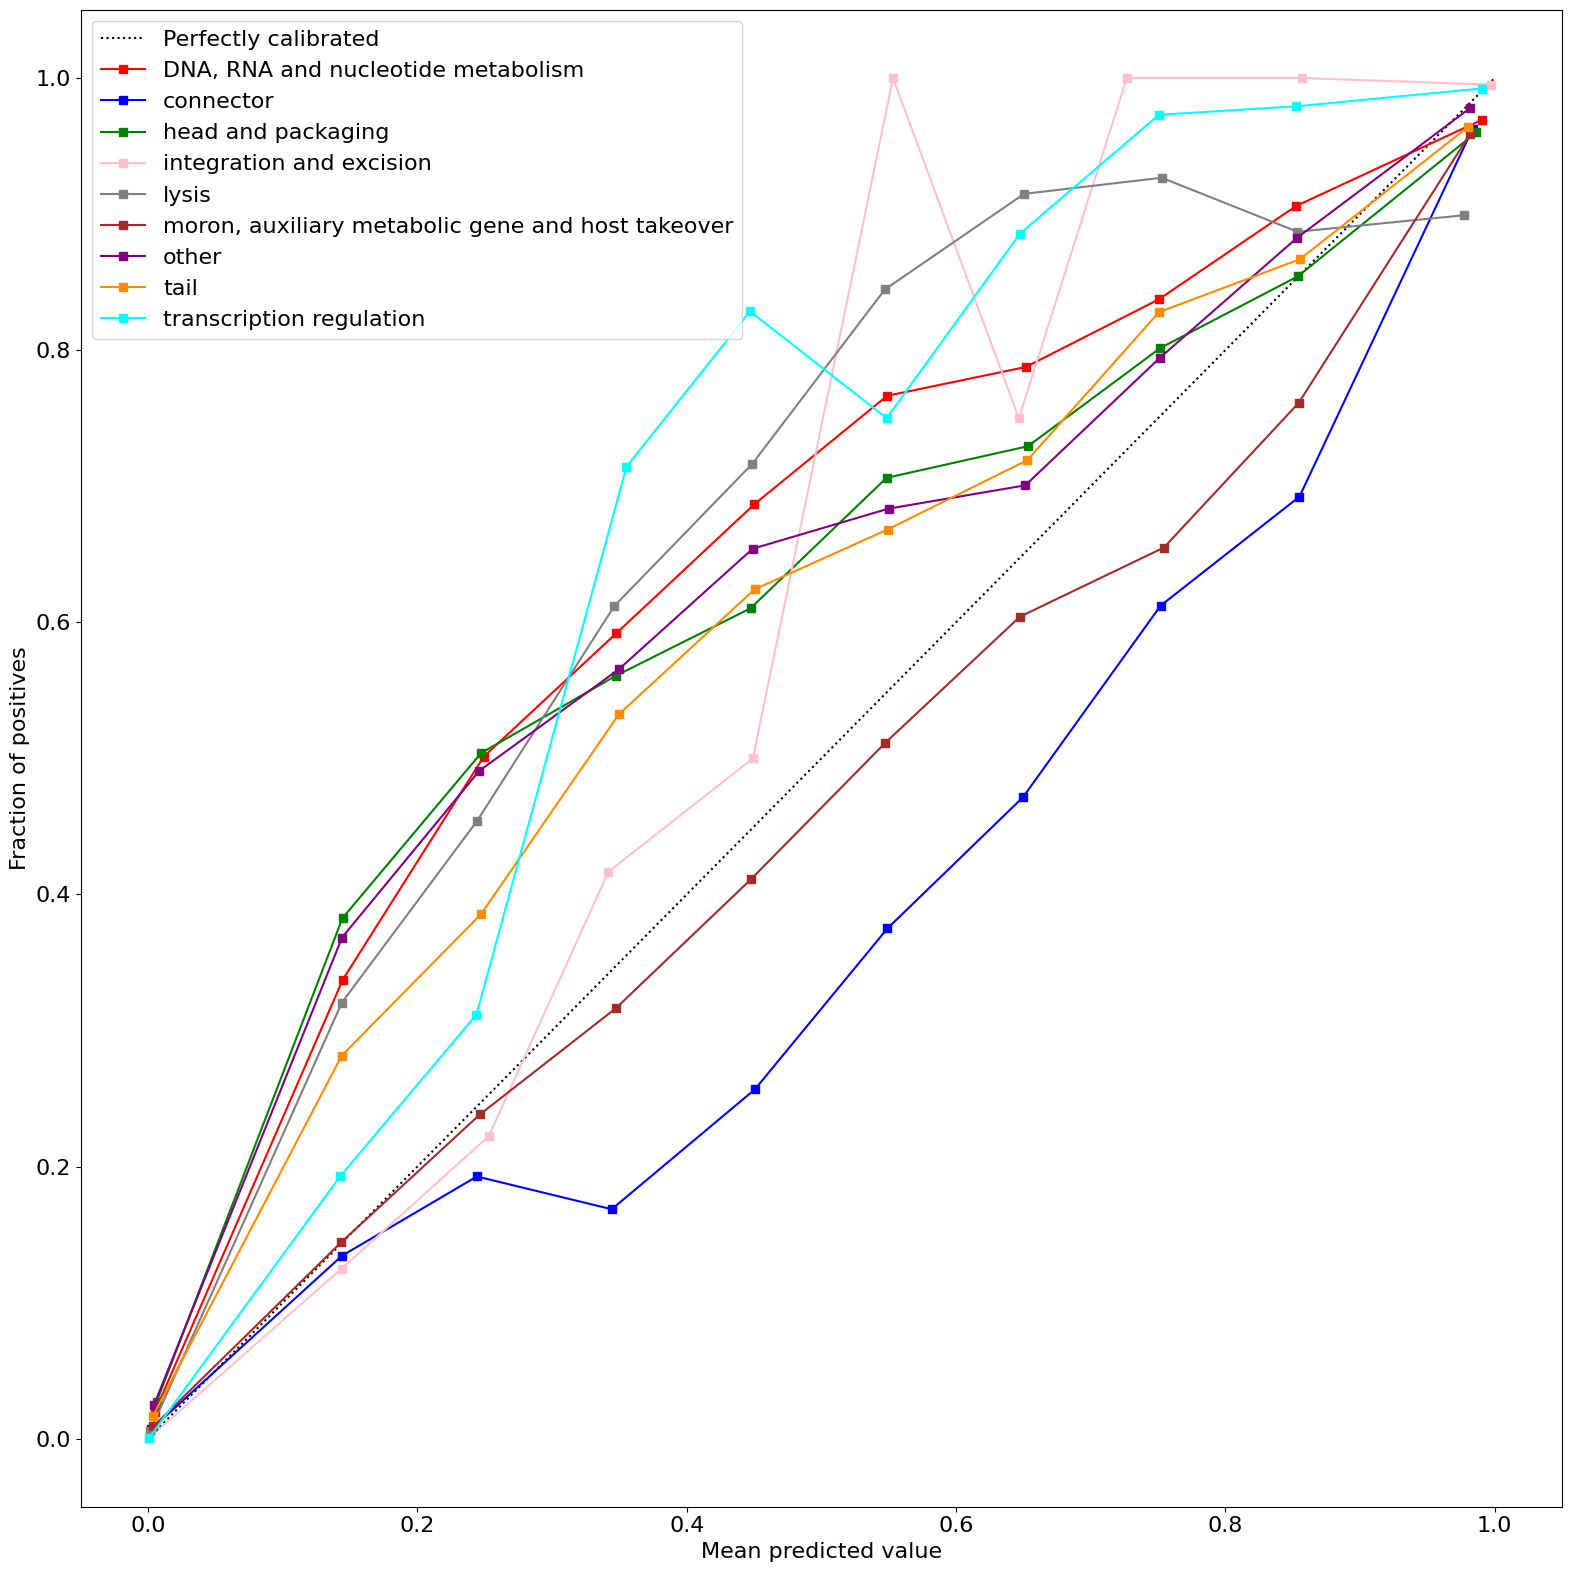

In [25]:
from sklearn.calibration import calibration_curve


# def plot_calibration_curve(name, fig_index, ytest, probs):
#     """Plot calibration curve for est w/o and with calibration. """
    

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i in range(len(label_binarizer.classes_)-1):
    name = label_binarizer.classes_[i]
    ytest = testY[:,i]
    probs = predY[:, i]

    frac_of_pos, mean_pred_value = calibration_curve(ytest, probs, n_bins=10)

    plt.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}', color=phrog_palette[name])

    
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="upper left")
#ax1.legend.remove()
#plt.set_title(f'Calibration plot ({name})')
    
plt.tight_layout()
plt.savefig('calibration_plot_analysis_07072023.png', dpi=300)
plt.show()

In [26]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams['font.size'] = 20

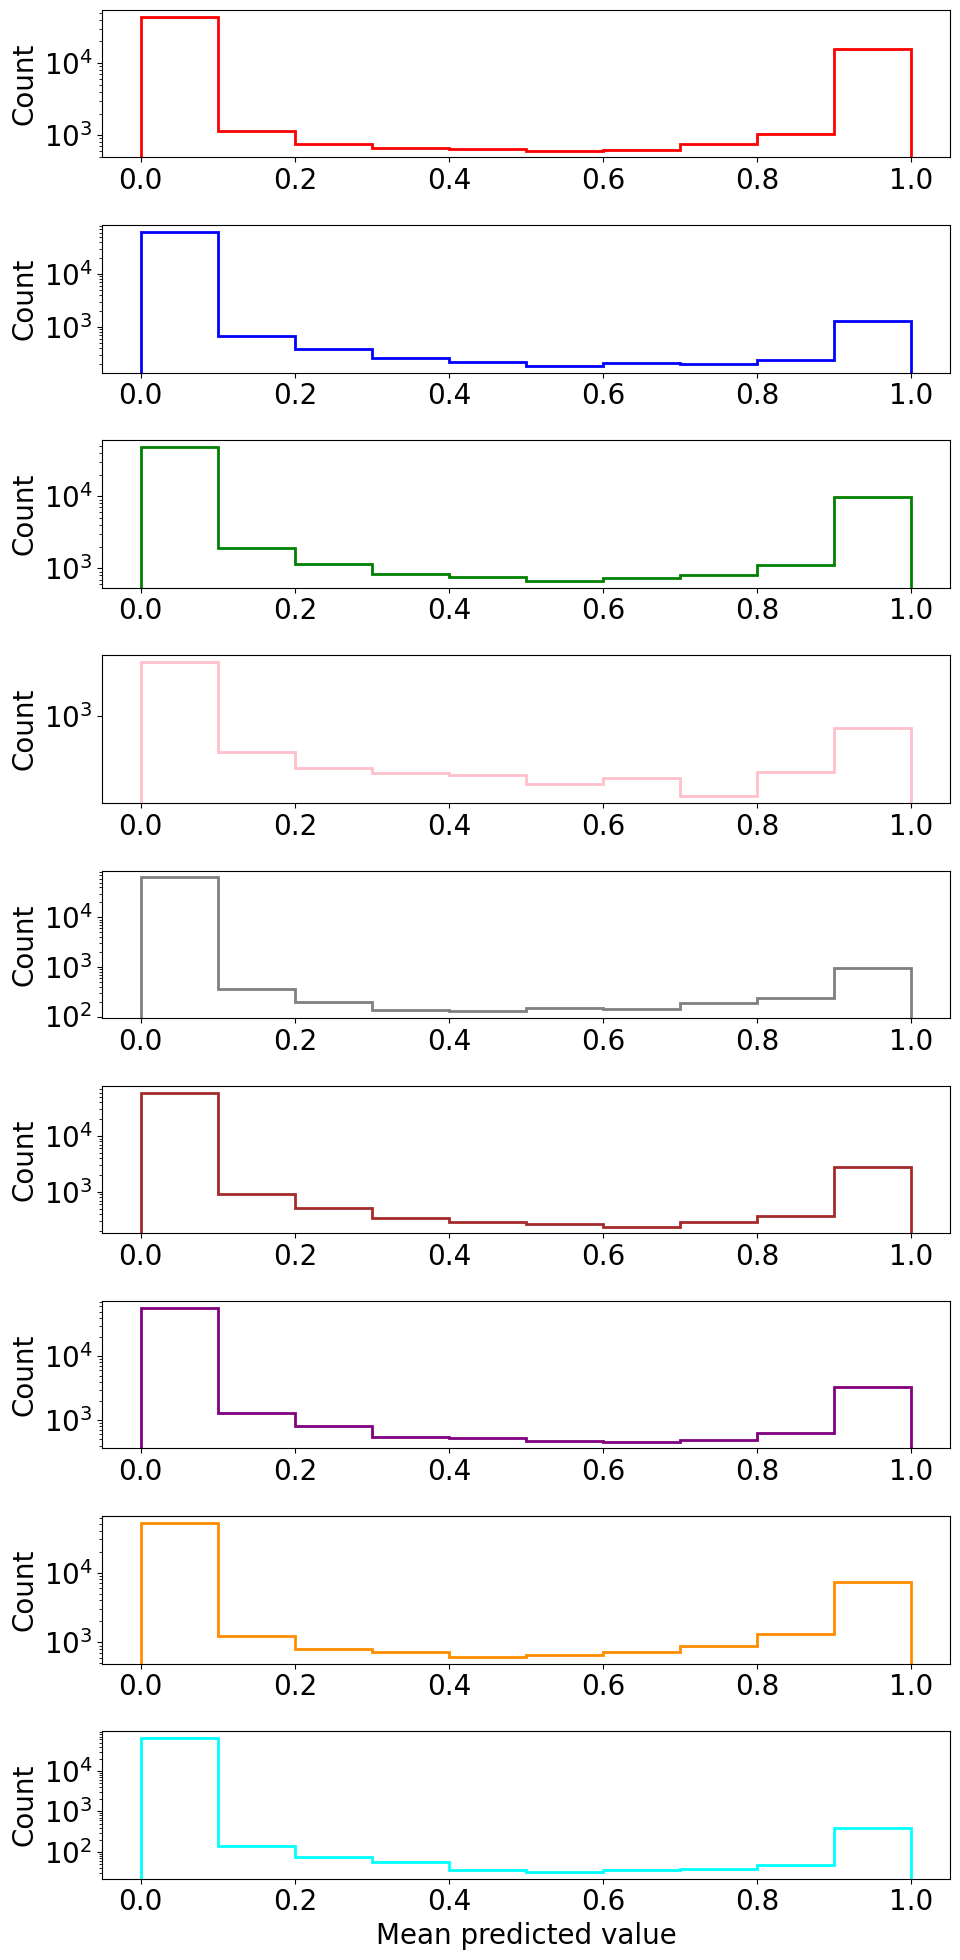

In [27]:
from sklearn.calibration import calibration_curve


# def plot_calibration_curve(name, fig_index, ytest, probs):
#     """Plot calibration curve for est w/o and with calibration. """
    
    

fig = plt.figure(1, figsize=(10, 20))


for i in range(len(label_binarizer.classes_)-1):
    name = label_binarizer.classes_[i]
    ytest = testY[:,i]
    probs = predY[:, i]

    frac_of_pos, mean_pred_value = calibration_curve(ytest, probs, n_bins=10)


    ax = plt.subplot2grid((len(label_binarizer.classes_)-1, 1), (i, 0))
    ax.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2, color=phrog_palette[name])
    ax.set_ylabel("Count")
    ax.set_yscale('log')
    
ax.set_xlabel("Mean predicted value")


#ax1.legend.remove()
#ax1.set_title(f'Calibration plot ({name})')
    
plt.tight_layout()
plt.savefig('calibration_plot_analysis_hists_07072023.png', dpi=300)
plt.show()

# figure 4b

In [28]:
cs_assignment = pd.read_csv('efam_clusters_predictions.tsv', sep='\t')
phrog_predicted_clusters_dict = lb
cs_assignment_minus_phrogs = cs_assignment[~cs_assignment['cluster'].isin(phrog_predicted_clusters_dict.keys())]

In [29]:
counts = []
for i in range(len(label_binarizer.classes_)-1):
    label_df = cs_assignment_minus_phrogs[cs_assignment_minus_phrogs['label'] == label_binarizer.classes_[i]]
    #print(decision_threshold[label_binarizer.classes_[i]])
    label_df = label_df[label_df['average_prob'] > decision_threshold[label_binarizer.classes_[i]]]
    counts.append(len(label_df))

threshold_df = pd.DataFrame({'category': list(label_binarizer.classes_)[0:-1], 'counts': counts})

In [30]:
plt.rcParams["figure.figsize"]=12,8
sns.set(font_scale=1.5)
max_width=17

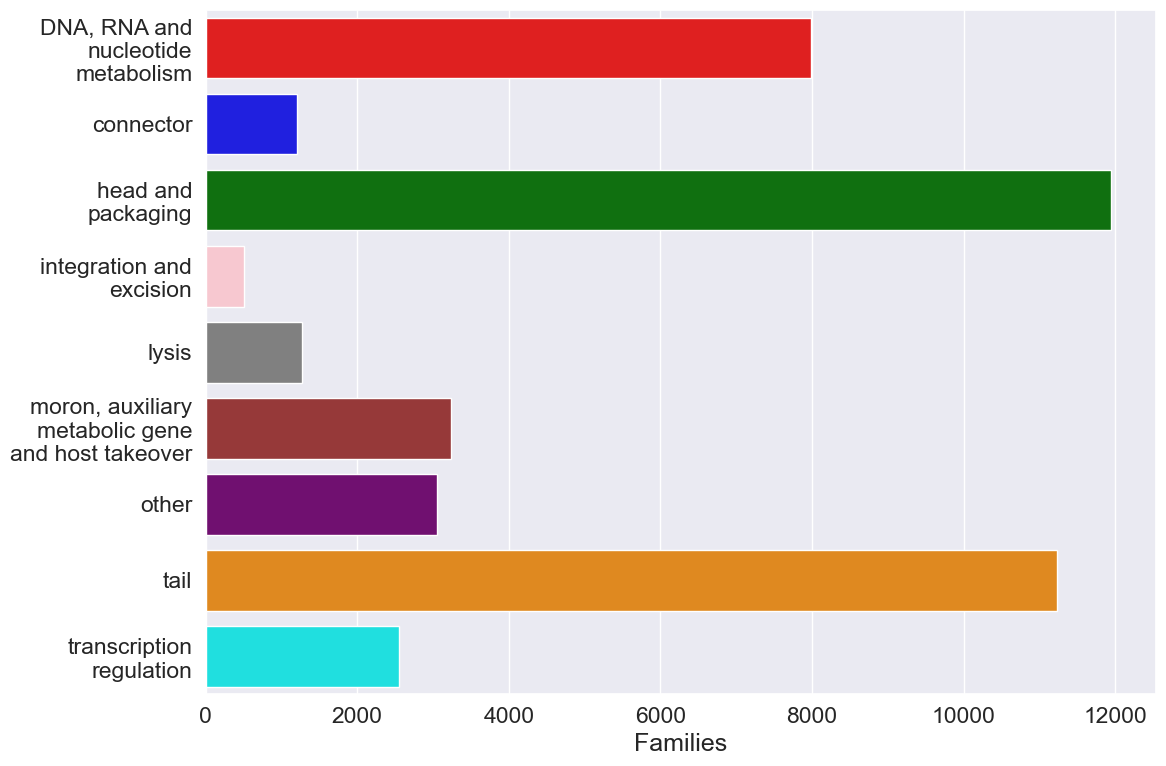

In [31]:
threshold_df_no_unknown = threshold_df[threshold_df['category'] != 'unknown']
g = sns.barplot(x='counts', y='category', palette=phrog_palette, data=threshold_df_no_unknown)

g.set_xlabel('Families')
g.set_ylabel('')
g.set_yticklabels(textwrap.fill(x.get_text(), max_width) for x in g.get_yticklabels())

plt.tight_layout()
plt.savefig('efam_clusters_not_PHROG_thresholded_to_max_f1_02212023', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
efam_super_annote['cluster'] = efam_super_annote.index

In [33]:
efam_db_with_predictions_not_phrog_hit = cs_assignment_minus_phrogs.join(efam_super_annote.set_index('cluster'), on='cluster', how='left')
efam_db_with_predictions_not_phrog_hit_unannotated = efam_db_with_predictions_not_phrog_hit[efam_db_with_predictions_not_phrog_hit['Annotation Status'] == 'Unannotated']

In [34]:
counts = []
for i in range(len(label_binarizer.classes_)-1):
    label_df = efam_db_with_predictions_not_phrog_hit_unannotated[efam_db_with_predictions_not_phrog_hit_unannotated['label'] == label_binarizer.classes_[i]]
    label_df = label_df[label_df['average_prob'] > decision_threshold[label_binarizer.classes_[i]]]
    counts.append(len(label_df))

threshold_further_df = pd.DataFrame({'category': list(label_binarizer.classes_)[0:-1], 'counts': counts})

In [35]:
print('Number of newly annotated EFAM VPFs: {0}' ''.format(sum(threshold_further_df['counts'][:-1])))

Number of newly annotated EFAM VPFs: 26770


In [36]:
print('Total EFAM VPFs annotated prior: {0}' ''.format(len(cs_assignment) - len(efam_db_with_predictions_not_phrog_hit_unannotated)))

Total EFAM VPFs annotated prior: 91156


In [37]:
new_frac = sum(threshold_further_df['counts'][:-1]) / (len(cs_assignment) - len(efam_db_with_predictions_not_phrog_hit_unannotated))
print('% annotation gain: {0}' ''.format(new_frac))

% annotation gain: 0.29367238580016675


# figure 4c

In [38]:
category = 'integration and excision'

In [39]:
clusters_with_integration_hhsearch_hit = [k for k,v in lb.items() if v[0] == category]

In [40]:
integration_excision_efam_followup = cs_assignment[(cs_assignment['cluster'].isin(clusters_with_integration_hhsearch_hit)) | (cs_assignment['label'] == category)]
integration_excision_efam_followup = integration_excision_efam_followup.join(efam_super_annote.set_index('cluster'), on='cluster', how='left')
integration_excision_efam_followup['decision_threshold'] = [1 if x > decision_threshold[category] else 0 for x in integration_excision_efam_followup['average_prob']]
integration_excision_efam_followup['efam_e_threshold'] = [1 if x in phrog_predicted_clusters_dict.keys() else 0 for x in integration_excision_efam_followup['cluster']]
integration_excision_efam_followup['efam_e_threshold_category'] = [1 if x in clusters_with_integration_hhsearch_hit else 0 for x in integration_excision_efam_followup['cluster']]

In [41]:
## remove the clusters not predicted integration and excision for the purposes of the figure
df = integration_excision_efam_followup
df = df[df['label'] == category]

In [42]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16
plt.rcParams["figure.frameon"] = False

/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_1811/2886258084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family {0} probability' ''.format(category)] = df['average_prob']
/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_1811/2886258084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family average protein length'] = df['average_protein_length']
/var/folders/2z/g2b17vp16h5dd311_396ckc80000gn/T/ipykernel_1811/2886258084.py:3: SettingWithCopyWarning: 
A value is tryi

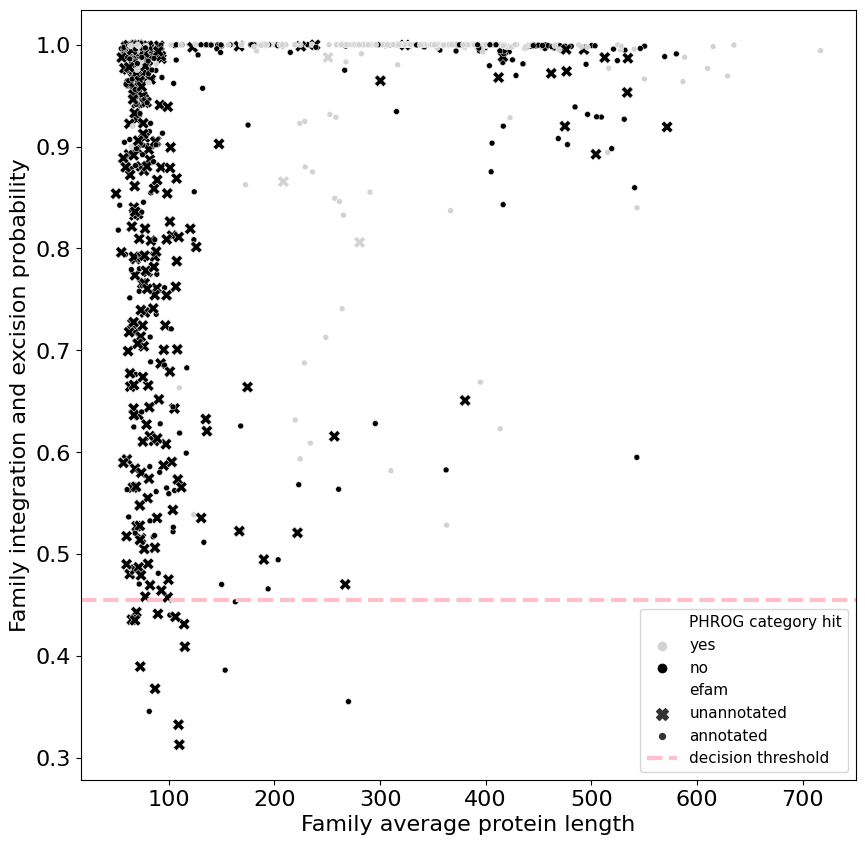

In [43]:
df['Family {0} probability' ''.format(category)] = df['average_prob']
df['Family average protein length'] = df['average_protein_length']
df['PHROG category hit'] = ['yes' if x == 1 else 'no' for x in df['efam_e_threshold_category']]
df['efam'] = ['annotated' if x == 'Annotated' else 'unannotated' for x in df['Annotation Status']]

plt.figure(frameon=False)
g = sns.scatterplot(
    y='Family {0} probability' ''.format(category),
    x='Family average protein length',
    hue='PHROG category hit',
    palette=['lightgray', 'black'],
    hue_order=['yes','no'],
    style='efam',
    size_order=['unannotated', 'annotated'],
    size='efam',
    data=df
)

g.axhline(decision_threshold[category], color='pink', linestyle='--', lw=3, label='decision threshold')
g.legend(fontsize=11)

plt.savefig('efam_integration_excision_threshold.png', dpi=300, )
plt.show()

In [44]:
df_e = df[df['efam_e_threshold_category'] == 0]
df_e_threshold_1 = df_e[df_e['decision_threshold'] == 1]
df_filtered_e_decision_threshold_unnanottated = df_e_threshold_1[df_e_threshold_1['Annotation Status'] == 'Unannotated']

In [45]:
df_e_threshold_1_annotated = df_e_threshold_1[df_e_threshold_1['Annotation Status'] == 'Annotated']
df_e_threshold_1_greater = df_e_threshold_1_annotated[df_e_threshold_1_annotated['average_protein_length'] > 120]
df_e_threshold_1_less = df_e_threshold_1_annotated[df_e_threshold_1_annotated['average_protein_length'] < 120]

In [46]:
a = [ll.split('=')[0].split('\'') for l in list(df_e_threshold_1_greater['Annotation(s) / Hit(s):']) for ll in l.strip().split(';')]
a = [l[1].strip() for l in a if len(l) > 1]
a = [l.lower() for l in a if len(l) > 0]

b = [ll.split('=')[0].split('\'') for l in list(df_e_threshold_1_less['Annotation(s) / Hit(s):']) for ll in l.strip().split(';')]
b = [l[1].strip() for l in b if len(l) > 1]
b = [l.lower() for l in b if len(l) > 0]

a = pd.Series(a)
b = pd.Series(b)

In [47]:
a.value_counts()[a.value_counts() > 10]

no annotation found                          131
very late expression factor 1                113
phage integrase family                       105
phage_integrase domain-containing protein     57
uncharacterized protein                       53
integrase                                     41
phage integrase                               29
phage integrase family protein                25
site-specific integrase                       23
integrase family protein                      23
hypothetical protein                          17
putative phage integrase family protein       13
dtype: int64

In [48]:
b.value_counts()[b.value_counts() > 10]

no annotation found                          147
helix-turn-helix domain                       80
hth_17 domain-containing protein              53
uncharacterized protein                       25
prophage cp4-57 regulatory protein (alpa)     22
dtype: int64

# supplemental table 5

In [49]:
df_filtered_e_decision_threshold_unnanottated.to_csv('efam_{0}_filtered.csv' ''.format(category), index=False)